/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classical baseline (scaled features) accuracy: 93.33%
Depth=1, entanglement=none: mean=85.33%, std=4.99%, min=80.00%, max=93.33%
Depth=1, entanglement=chain: mean=68.00%, std=4.52%, min=63.33%, max=73.33%
Depth=2, entanglement=none: mean=92.00%, std=3.40%, min=86.67%, max=96.67%
Depth=2, entanglement=chain: mean=71.33%, std=5.81%, min=63.33%, max=80.00%
Depth=3, entanglement=none: mean=70.00%, std=6.67%, min=60.00%, max=80.00%
Depth=3, entanglement=chain: mean=64.67%, std=12.04%, min=43.33%, max=76.67%
Saved robustness plot as 'robustness_accuracy.png'
Best config by mean accuracy: depth=2, entanglement=none
Saved PCA comparison plot as 'pca_comparison.png'


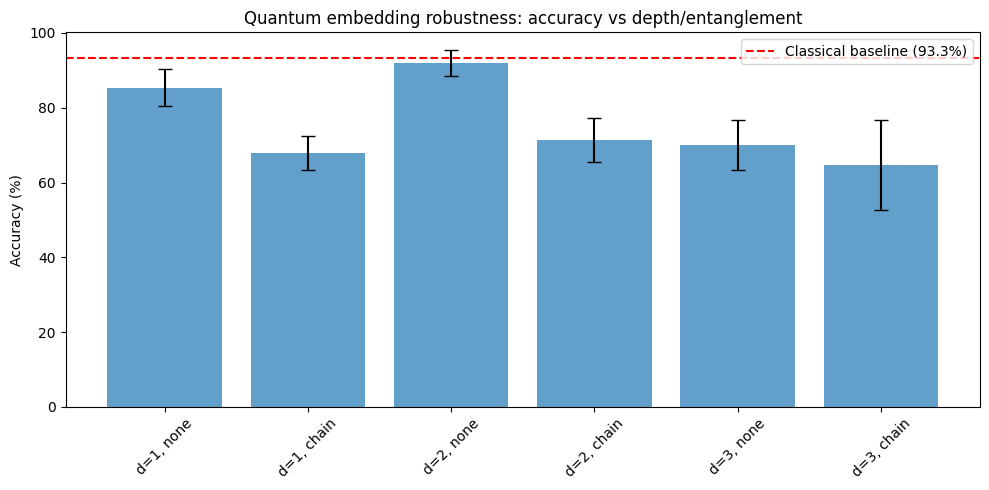

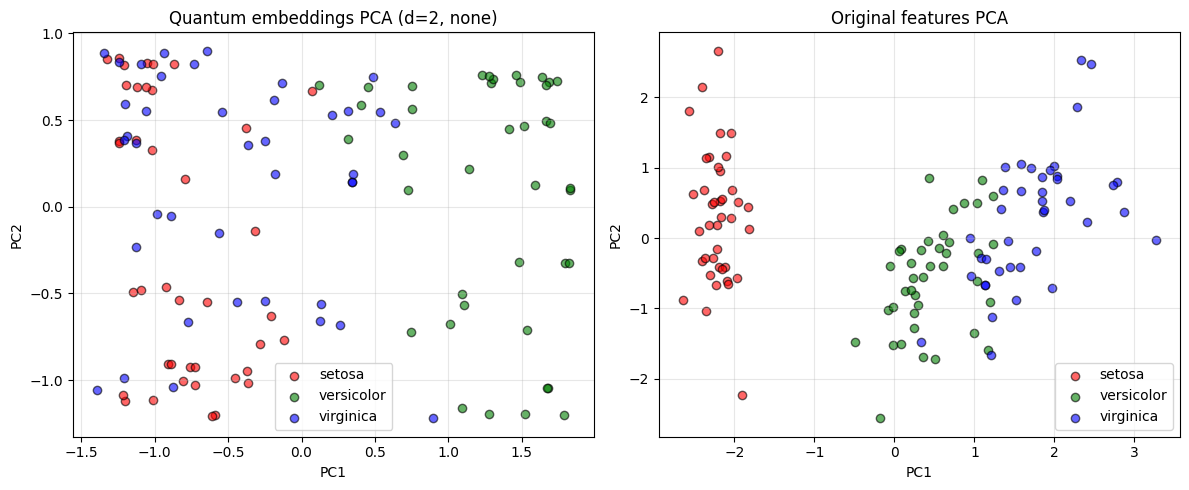

In [2]:
import pennylane as qml
from pennylane import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ============================================
# 1. Load and preprocess data
# ============================================
iris = datasets.load_iris()
X = iris.data  # shape (150, 4)
y = iris.target  # 0,1,2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Classical baseline
clf_orig = LogisticRegression(max_iter=200, multi_class="auto")
clf_orig.fit(X_train_scaled, y_train)
y_pred_orig = clf_orig.predict(X_test_scaled)
acc_orig = accuracy_score(y_test, y_pred_orig)
print(f"Classical baseline (scaled features) accuracy: {acc_orig*100:.2f}%")

# ============================================
# 2. Quantum embedding setup (configurable)
# ============================================
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

def feature_map(x):
    """Simple angle embedding: RY on each qubit."""
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)

def entangling_layer(entanglement_type):
    """Apply entangling gates according to entanglement_type."""
    if entanglement_type == "none":
        return
    elif entanglement_type == "chain":
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    else:
        raise ValueError(f"Unknown entanglement_type: {entanglement_type}")

def layered_circuit(x, params, depth, entanglement_type):
    """
    depth: number of (feature_map + param_layer + entanglement) blocks.
    params shape: (depth, n_qubits)
    """
    for d in range(depth):
        feature_map(x)
        for i in range(n_qubits):
            qml.RY(params[d, i], wires=i)
        entangling_layer(entanglement_type)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def make_qnode(depth, entanglement_type):
    @qml.qnode(dev)
    def quantum_embedding(x, params):
        return layered_circuit(x, params, depth=depth, entanglement_type=entanglement_type)
    return quantum_embedding

def make_embeddings(X, quantum_embedding, params):
    emb = []
    for x in X:
        emb.append(quantum_embedding(x, params))
    return np.array(emb)

# ============================================
# 3. Robustness experiment over configs/seeds
# ============================================
depth_values = [1, 2, 3]
entanglement_types = ["none", "chain"]
n_seeds = 5

results = []  # list of dicts: config + stats

for depth in depth_values:
    for ent_type in entanglement_types:
        quantum_embedding = make_qnode(depth, ent_type)

        acc_list = []
        for seed in range(n_seeds):
            np.random.seed(seed)
            # params shape: (depth, n_qubits), small random values
            params = np.random.uniform(low=-0.5, high=0.5, size=(depth, n_qubits))

            # Generate embeddings
            X_train_emb = make_embeddings(X_train_scaled, quantum_embedding, params)
            X_test_emb = make_embeddings(X_test_scaled, quantum_embedding, params)

            # Train logistic regression on embeddings
            clf_q = LogisticRegression(max_iter=200)
            clf_q.fit(X_train_emb, y_train)
            y_pred_q = clf_q.predict(X_test_emb)
            acc_q = accuracy_score(y_test, y_pred_q)
            acc_list.append(acc_q)

        acc_array = np.array(acc_list)
        result = {
            "depth": depth,
            "entanglement": ent_type,
            "accuracies": acc_array,
            "mean": np.mean(acc_array),
            "std": np.std(acc_array),
            "min": np.min(acc_array),
            "max": np.max(acc_array),
        }
        results.append(result)
        print(
            f"Depth={depth}, entanglement={ent_type}: "
            f"mean={result['mean']*100:.2f}%, std={result['std']*100:.2f}%, "
            f"min={result['min']*100:.2f}%, max={result['max']*100:.2f}%"
        )

# ============================================
# 4. Visualization: robustness + PCA
# ============================================
# 4.1 Robustness plot: accuracy distribution for each config
config_labels = []
config_means = []
config_stds = []

for r in results:
    label = f"d={r['depth']}, {r['entanglement']}"
    config_labels.append(label)
    config_means.append(r["mean"])
    config_stds.append(r["std"])

plt.figure(figsize=(10, 5))

# Bar plot with error bars (mean ± std)
x_pos = np.arange(len(config_labels))
plt.bar(x_pos, np.array(config_means)*100, yerr=np.array(config_stds)*100, alpha=0.7, capsize=5)
plt.axhline(acc_orig*100, color="red", linestyle="--", label=f"Classical baseline ({acc_orig*100:.1f}%)")
plt.xticks(x_pos, config_labels, rotation=45)
plt.ylabel("Accuracy (%)")
plt.title("Quantum embedding robustness: accuracy vs depth/entanglement")
plt.legend()
plt.tight_layout()
plt.savefig("robustness_accuracy.png", dpi=150)
print("Saved robustness plot as 'robustness_accuracy.png'")

# 4.2 PCA scatter for one selected quantum config vs classical PCA
# Choose the best mean configuration (just for nicer picture)
best_idx = int(np.argmax([r["mean"] for r in results]))
best_config = results[best_idx]
best_depth = best_config["depth"]
best_ent = best_config["entanglement"]
print(f"Best config by mean accuracy: depth={best_depth}, entanglement={best_ent}")

# Rebuild embeddings for that config using a fixed seed
np.random.seed(0)
best_params = np.random.uniform(low=-0.5, high=0.5, size=(best_depth, n_qubits))
best_qnode = make_qnode(best_depth, best_ent)
X_train_best_emb = make_embeddings(X_train_scaled, best_qnode, best_params)

# PCA on quantum embeddings
pca_q = PCA(n_components=2)
X_train_q_pca = pca_q.fit_transform(X_train_best_emb)

# PCA on original features
pca_orig = PCA(n_components=2)
X_train_orig_pca = pca_orig.fit_transform(X_train_scaled)

plt.figure(figsize=(12, 5))

colors = ['red', 'green', 'blue']
labels = iris.target_names

# Quantum PCA
plt.subplot(1, 2, 1)
for i, color in enumerate(colors):
    mask = y_train == i
    plt.scatter(
        X_train_q_pca[mask, 0],
        X_train_q_pca[mask, 1],
        c=color,
        label=labels[i],
        alpha=0.6,
        edgecolors="k",
    )
plt.title(f"Quantum embeddings PCA (d={best_depth}, {best_ent})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, alpha=0.3)

# Classical PCA
plt.subplot(1, 2, 2)
for i, color in enumerate(colors):
    mask = y_train == i
    plt.scatter(
        X_train_orig_pca[mask, 0],
        X_train_orig_pca[mask, 1],
        c=color,
        label=labels[i],
        alpha=0.6,
        edgecolors="k",
    )
plt.title("Original features PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("pca_comparison.png", dpi=150)
print("Saved PCA comparison plot as 'pca_comparison.png'")
